``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

---
# **CNNs para Classificação**
---

```OBS: Quando pedido, realize a operação na célula correspondente atribuindo o resultado na variável indicada. Não altere os nomes das variáveis utilizadas. Você pode utilizar células adicionais para realizar testes, utilizando variáveis auxiliares para visualizar resultados intermediários.```

---
## **01 - Imports**
---

In [ ]:
%%capture
%!pip install torchsummary

In [ ]:
# Modelagem e dados
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils import data

# Avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Outros
import zipfile
import os
import glob
import numpy as np

---
## **02 - Datasets e DataLoaders**
---

O **Dataset** utilizado para esse exemplo é o *CIFAKE*, um dataset com $120000$ imagens com $50\%$ sendo verdadeiras (*CIFAR-10*) e $50\%$ sendo geradas por *Stable Diffusion* (Fakes).


In [ ]:
%%capture
!wget https://www.dropbox.com/scl/fi/fjto0e19s54c13ucezzch/cifake.zip?rlkey=s0b5diqzw5f8vguklapfnfsc6&dl=0

In [ ]:
def extract_file(src_file, dst_folder="cifake"):
    if not os.path.exists(dst_folder):
        os.mkdir(dst_folder)
    with zipfile.ZipFile(src_file, 'r') as zip_ref:
        zip_ref.extractall(dst_folder)

In [ ]:
filename = glob.glob("*.zip*")[0]
extract_file(filename)
os.remove(filename)

### **Q1**

Usando o `transforms.Compose` defina um conjunto de transformações que deve se aplicado nos conjunto de treino e de validação. **(+10)**

Transformações de treino:
- `ToTensor()`
- `ColorJitter(hue=.3, brightness=.5)`
- `RandomRotation(degrees=[0, 180])`
- `RandomHorizontalFlip(p=0.5)`
- `Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])`

Transformações da validação:
- `ToTensor()`
- `Normalize(mean=[.485,.456,.406], std=[.229,.224,.225])`


Referência: [PyTorch Transforms](https://pytorch.org/vision/0.9/transforms.html)

In [ ]:
# Transformações de treino e de validação

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=.3, brightness=.5),
    transforms.RandomRotation(degrees=[0, 180]),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])

transform_eval  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])

In [ ]:
def train_val_split(dataset, train_percentage=0.85):
    global transform, transform_eval
    length = len(dataset)
    indices = list(range(length))
    np.random.shuffle(indices)
    len_train = int(np.floor(train_percentage * length))
    train_idx, val_idx = indices[:len_train], indices[len_train:]
    return train_idx, val_idx

### **Q2**

Crie os **DataLoaders** para carregar os dados dos **Datasets** gerados (`train_ds`, `val_ds`, `test_ds`): **(+10)**
- Crie os `DataLoaders` utilizado `batch_size=64` para o conjunto de treino e `batch_size=128` para os conjuntos de teste e validação;
- Use `shuffle=True`, `num_workers=2` e `pin_memory=True`.

In [ ]:
train_ds = datasets.ImageFolder(root="cifake/train", transform=transform_train)

val_ds = datasets.ImageFolder(root="cifake/train", transform=transform_eval)
train_idx, val_idx = train_val_split(train_ds)
train_ds = data.Subset(train_ds, train_idx)
val_ds = data.Subset(val_ds, val_idx)

test_ds = datasets.ImageFolder(root="cifake/test", transform=transform_eval)

In [ ]:
# DataLoaders

train_dl = data.DataLoader(train_ds, batch_size=64, shuffle=True,
                           num_workers=2, pin_memory=True)

val_dl   = data.DataLoader(val_ds, batch_size=128, shuffle=True,
                           num_workers=2, pin_memory=True)

test_dl  = data.DataLoader(test_ds, batch_size=128, shuffle=True,
                           num_workers=2, pin_memory=True)

---
## **03 - Visualizando os Exemplos**
---

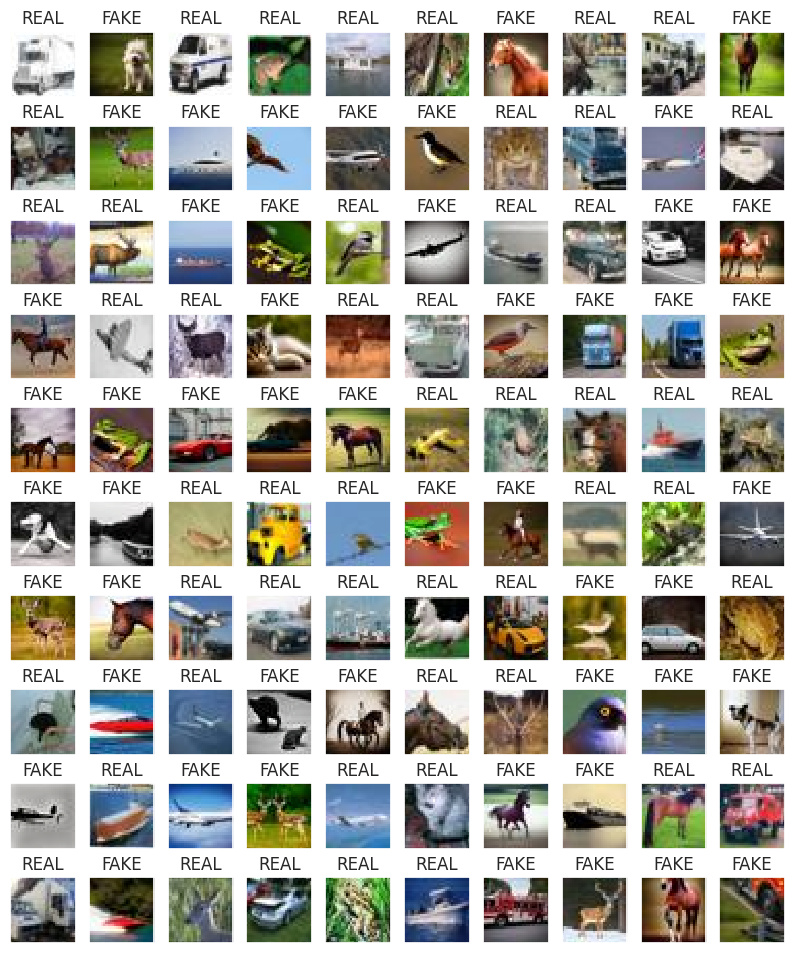

In [ ]:
instances, targets = next(iter(test_dl))

inv_norm = transforms.Normalize(
    mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std = [1 / 0.229, 1 / 0.224, 1 / 0.225]
)
ins = inv_norm(instances)

w = 10
fig, ax = plt.subplots(w, w, figsize=(10, 12))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(ins[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = int(targets[i * w + j].item())
        ax[i][j].set_title(test_ds.classes[label])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

---
## **04 - Gerando o Modelo**
---

### **Q3**

Crie o modelo de classificação. Defina a classe `MyCNN` que herda de `nn.Module `. **(+30)**

Na função `__init__` defina a arquitetura:
- Use `nn.Sequential` para gerar o modelo.
- O modelo terá as seguintes camadas:
 - `Conv2d: in_channels=3, out_channels=16, kernel_size=3`
 - `ReLU`
 - `Conv2d: in_channels=16, out_channels=32, kernel_size=3`
 - `ReLU`
 - `MaxPool2d: kernel_size=2, stride=2`
 - `Conv2d: in_channels=32, out_channels=32, kernel_size=3`
 - `ReLU`
 - `Conv2d: in_channels=32, out_channels=32, kernel_size=3`
 - `ReLU`
 - `MaxPool2d: kernel_size=2, stride=2`
 - `Flatten`
 - `Linear: out_features=256`
 - `ReLU`
 - `Dropout: p=.5`
 - `Linear: out_features=256`
 - `ReLU`
 - `Dropout: p=.5`
 - `Linear: out_features=1`
 - `Sigmoid`

- Use o método `forward` para executar o modelo a partir do atributo `cnn`.

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=32*5*5, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=.5),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=.5),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logit = self.cnn(x)
        return logit

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
classifier = MyCNN().to(device)

summary(classifier, input_size=(3,32,32), batch_size=64, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 30, 30]             448
              ReLU-2           [64, 16, 30, 30]               0
            Conv2d-3           [64, 32, 28, 28]           4,640
              ReLU-4           [64, 32, 28, 28]               0
         MaxPool2d-5           [64, 32, 14, 14]               0
            Conv2d-6           [64, 32, 12, 12]           9,248
              ReLU-7           [64, 32, 12, 12]               0
            Conv2d-8           [64, 32, 10, 10]           9,248
              ReLU-9           [64, 32, 10, 10]               0
        MaxPool2d-10             [64, 32, 5, 5]               0
          Flatten-11                  [64, 800]               0
           Linear-12                  [64, 256]         205,056
             ReLU-13                  [64, 256]               0
          Dropout-14                  [

---
## **05 - Treinamento**
---

### **Q4**

Defina a função de perda e o otimizador: **(+10)**
- Use a função de perda **BCE**;
- Use o otimizador **Adam** (`lr=1e-4`).

Referências:
- [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
- [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=classifier.parameters(), lr=1e-4)

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # Fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
    model.train()

    train_loss = AverageMeter()
    for sample, target in train_dl:
        sample = sample.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(sample).flatten()

        loss = loss_fn(output, target.float())
        train_loss.update(loss.item(), len(sample))

        loss.backward()
        optimizer.step()

    return train_loss.avg

def validation_step(model, val_dl, loss_fn, device):
    model.eval()

    val_loss = AverageMeter()
    with torch.no_grad():
        for sample, target in val_dl:
            sample = sample.to(device)
            target = target.to(device)

            output = model(sample).flatten()
            loss = loss_fn(output, target.float())
            val_loss.update(loss.item(), len(sample))

    return val_loss.avg

In [ ]:
history_cs = {
    "train_loss": [],
    "val_loss": []
}

EPOCHS = 15

for epoch in range(EPOCHS):
    train_loss = train_step(classifier, train_dl, loss_fn, optimizer, device)
    val_loss   = validation_step(classifier, val_dl, loss_fn, device)

    history_cs["train_loss"].append(train_loss)
    history_cs["val_loss"].append(val_loss)

    print(f"Epoch [{epoch + 1}/{EPOCHS}]")
    print("-" * 35)
    print(f"Train loss: {round(train_loss, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Epoch [1/15]
-----------------------------------
Train loss: 0.533215
Valid. loss: 0.423499

Epoch [2/15]
-----------------------------------
Train loss: 0.426758
Valid. loss: 0.360958

Epoch [3/15]
-----------------------------------
Train loss: 0.390277
Valid. loss: 0.328515

Epoch [4/15]
-----------------------------------
Train loss: 0.372044
Valid. loss: 0.30525

Epoch [5/15]
-----------------------------------
Train loss: 0.355347
Valid. loss: 0.297403

Epoch [6/15]
-----------------------------------
Train loss: 0.345457
Valid. loss: 0.286582

Epoch [7/15]
-----------------------------------
Train loss: 0.336808
Valid. loss: 0.280246

Epoch [8/15]
-----------------------------------
Train loss: 0.330981
Valid. loss: 0.270556

Epoch [9/15]
-----------------------------------
Train loss: 0.321498
Valid. loss: 0.26851

Epoch [10/15]
-----------------------------------
Train loss: 0.316326
Valid. loss: 0.260641

Epoch [11/15]
-----------------------------------
Train loss: 0.313368


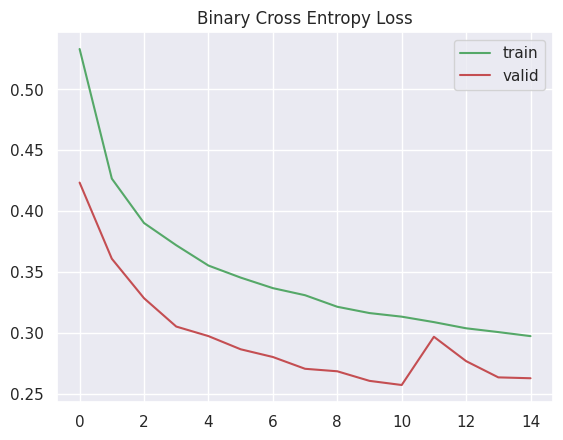

In [ ]:
fig = plt.figure()
plt.title("Binary Cross Entropy Loss")
plt.plot(history_cs["train_loss"], c="g", label="train")
plt.plot(history_cs["val_loss"], c="r", label="valid")
plt.legend()

---
## **06 - Transfer Learning**
---

### **Q5**

Utilize a `resnet50` para realizar o *Transfer Learning* no *Dataset* avaliado: **(+20)**

- Use a [`resnet50`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) do **PyTorch**;
- Inicialize o modelo com os pesos da **ImageNet** (`ResNet50_Weights.IMAGENET1K_V2`);
- Congele os parâmeteros da arquitetura (`requires_grad=False`);
- Defina um classficador usando `nn.Sequential`, esse classificador deve conter as camadas `Linear(resnet50.fc.in_features, 256)`, `ReLU()`, `Linear(256, 1)` e `Sigmoid()`;
- Atribua o classficador em `resnet50.fc`;
- Transfira o modelo para o dispositivo do ambiente.

In [ ]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

for parameter in resnet50.parameters():
    parameter.requires_grad = False

resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

classifier_tl = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


In [ ]:
summary(classifier_tl, input_size=(3,224,224), batch_size=64, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]           4,096
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]          16,384
      BatchNorm2d-12          [64, 256, 56, 56]             512
           Conv2d-13          [64, 256, 56, 56]          16,384
      BatchNorm2d-14          [64, 256,

### **Q6**

Usando o `transforms.Compose` defina um conjunto de transformações que deve se aplicado nos conjunto de treino e de validação. **(+10)**

Transformações de treino:
- `Resize(224)`
- `ToTensor()`
- `ColorJitter(hue=.3, brightness=.5)`
- `RandomRotation(degrees=[0, 180])`
- `RandomHorizontalFlip(p=0.5)`
- `Normalize(mean=[.485,.456,.406], std=[.229,.224,.225])`

Transformações da validação:
- `Resize(224)`
- `ToTensor()`
- `Normalize(mean=[.485,.456,.406], std=[.229,.224,.225])`


Referência: [PyTorch Transforms](https://pytorch.org/vision/0.9/transforms.html)

In [ ]:
transform_train_tl = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.ColorJitter(hue=.3, brightness=.5),
    transforms.RandomRotation(degrees=[0, 180]),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])

transform_eval_tl = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])

In [ ]:
train_dl.dataset.transform = transform_train_tl
val_dl.dataset.transform   = transform_eval_tl

### **Q7**

Defina a função de perda e o otimizador para o novo modelo: **(+10)**
- Use a função de perda **BCE**;
- Use o otimizador **Adam** (`lr=1e-4`).

Referências:
- [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
- [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=classifier_tl.parameters(), lr=1e-4)

In [ ]:
N_EPOCHS_TL = 15

history_tl = {
    "train_loss": [],
    "val_loss": []
}

for epoch in range(N_EPOCHS_TL):
    train_loss = train_step(classifier_tl, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(classifier_tl, val_dl, loss_fn, device)

    history_tl["train_loss"].append(train_loss)
    history_tl["val_loss"].append(val_loss)

    print(f"Epoch [{epoch + 1}/{N_EPOCHS_TL}]")
    print("-" * 35)
    print(f"Train loss: {round(train_loss, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Epoch [1/15]
-----------------------------------
Train loss: 0.601296
Valid. loss: 0.554683

Epoch [2/15]
-----------------------------------
Train loss: 0.574303
Valid. loss: 0.555017

Epoch [3/15]
-----------------------------------
Train loss: 0.567586
Valid. loss: 0.534519

Epoch [4/15]
-----------------------------------
Train loss: 0.566278
Valid. loss: 0.540465

Epoch [5/15]
-----------------------------------
Train loss: 0.5602 
Valid. loss: 0.533574

Epoch [6/15]
-----------------------------------
Train loss: 0.559514
Valid. loss: 0.536311

Epoch [7/15]
-----------------------------------
Train loss: 0.558473
Valid. loss: 0.525596

Epoch [8/15]
-----------------------------------
Train loss: 0.555979
Valid. loss: 0.511597

Epoch [9/15]
-----------------------------------
Train loss: 0.55373
Valid. loss: 0.520644

Epoch [10/15]
-----------------------------------
Train loss: 0.552733
Valid. loss: 0.527771

Epoch [11/15]
-----------------------------------
Train loss: 0.551342


---
## **07 - Testando Arquitetura Própria (MyCNN)**
---

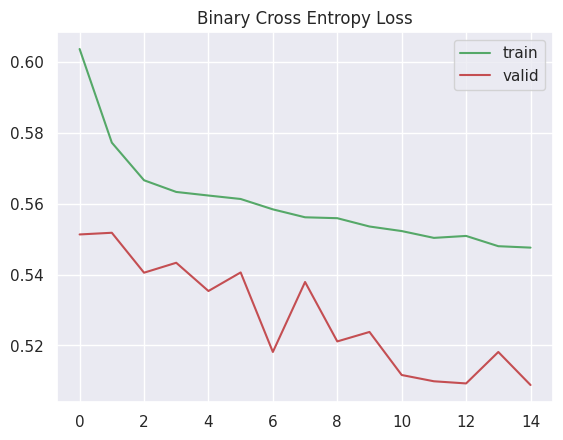

In [ ]:
fig = plt.figure()
plt.title("Binary Cross Entropy Loss")
plt.plot(history_tl["train_loss"], c="g", label="train")
plt.plot(history_tl["val_loss"], c="r", label="valid")
plt.legend()

In [ ]:
test_dl.dataset.transform = transform_eval
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        preds = classifier(test_instances)
    preds[preds > 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))

preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

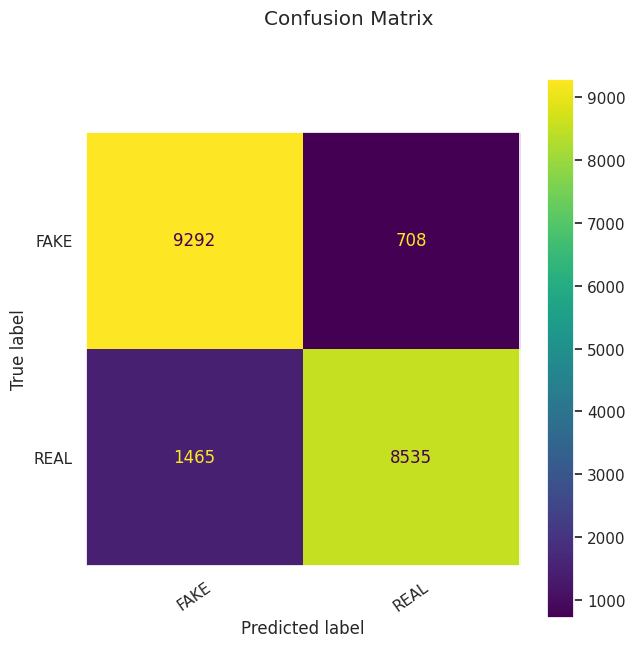

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Confusion Matrix")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [ ]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.86      0.93      0.90     10000
        REAL       0.92      0.85      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



---
## **08 - Testando Modelo com Transfer Learning**
---

In [ ]:
test_dl.dataset.transform = transform_eval_tl
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier_tl.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        preds = classifier_tl(test_instances)
    preds[preds > 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))

preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

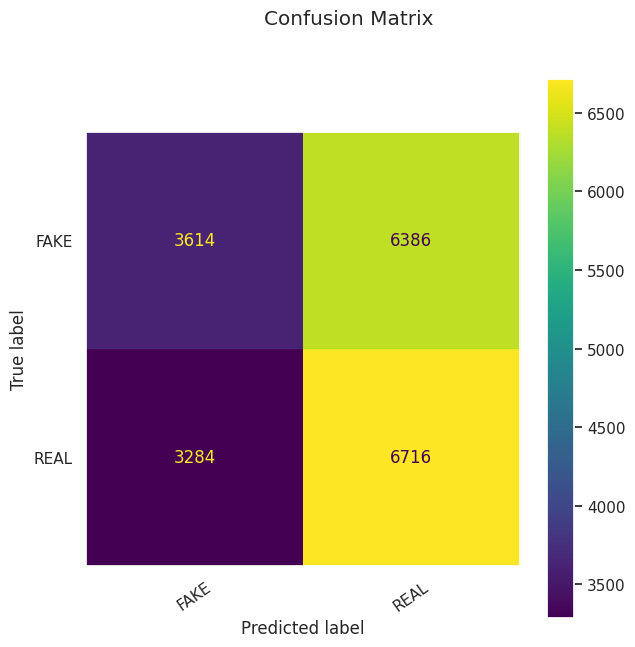

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Confusion Matrix")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [ ]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.52      0.36      0.43     10000
        REAL       0.51      0.67      0.58     10000

    accuracy                           0.52     20000
   macro avg       0.52      0.52      0.50     20000
weighted avg       0.52      0.52      0.50     20000

